# Load packages

In [1]:
%matplotlib inline 
from ifis_tools import database_tools as db 
from ifis_tools import asynch_manager as am 
from ifis_tools import auxiliar as aux
from wmf import wmf
import pandas as pd 
import numpy as np 
import os 
import pylab as pl
from string import Template
from param_ident import core 
from aclayer import core as ac

No se logra importar deap tools, por lo tanto se deshabilita SimuBasin.Calib_NSGAII


# Hydrographs comparison

In [2]:
wat = {'south': pd.read_csv('data/for_hlm/south_skunk/water_virtual.csv', index_col=0)}
wat.update({'turkey' : pd.read_csv('data/for_hlm/turkey/water_virtual.csv', index_col=0)})

In [3]:
f = open('data/for_hlm/south_skunk/control_vr5.sav','r')
L = f.readlines()
f.close()
L = [int(i) for i in L]
a = wat['south'].loc[L]
a.sort_values('Acum', ascending=False).shape

In [ ]:
def plot_sim(link, f1,f2, path = None):
    link = str(link)
    Q = {}
    for i in [4,5,6]:
        q = pd.read_msgpack('data/hlm_outputs/south/'+link+'_vr'+str(i)+'_.msg')
        Q.update({str(i): q})

    fig = pl.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    idx = Q['4']['Q'][f1:f2].index
    for k in Q.keys():
        pl.plot(idx, Q[k]['Q'][f1:f2].values, lw = 4, label = k)
    ax.legend(loc = 0 , fontsize = 'xx-large')
    ax.tick_params(labelsize = 22)
    ax.set_ylabel('Streamflow [$m^3 \cdot s^{-1}$]', size = 23)
    ax.grid()
    ax.set_xticks(idx[::200])
    ax.set_xlim(idx[0], idx[-1])
    if path is not None:
        pl.savefig(path, bbox_inches = 'tight')

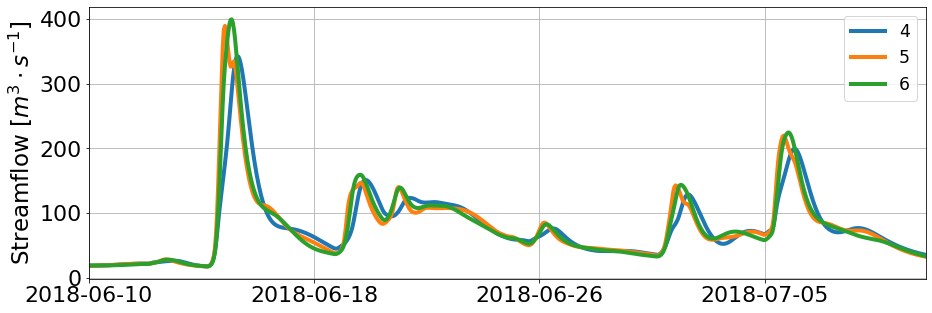

In [58]:
plot_sim(272677, '2018-06-10','2018-7-10', 'figures/272677_2018_6.png')

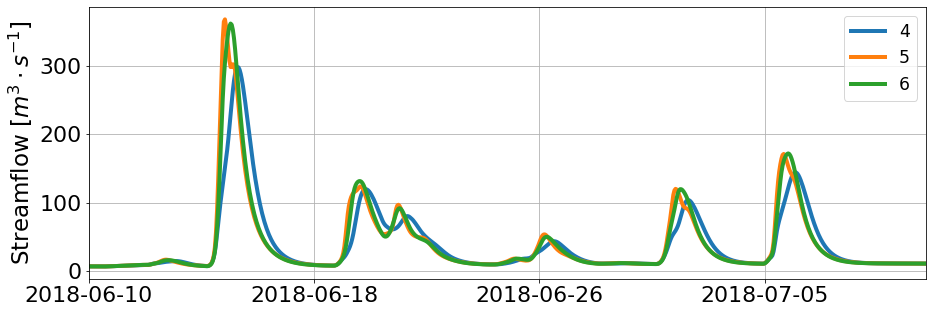

In [59]:
plot_sim(292255,'2018-06-10','2018-7-10', 'figures/292255_2018_9.png')

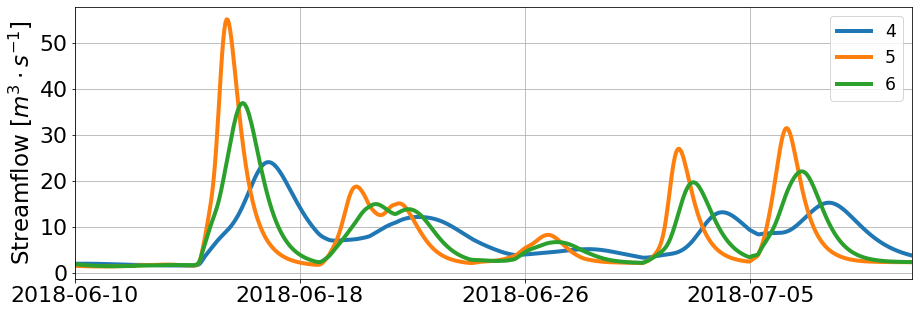

In [60]:
plot_sim(291344, '2018-06-10','2018-7-10','figures/291344_2018_9.png')

# Peak flow comparison

In [61]:
M = pd.read_msgpack('data/processed/south_event_met.msg')

## Qpeak by event comparison

In [89]:
def get_qpeak_acum(prod):
    qp = M.loc[M['product'] == prod, ['qpeakDiff','tpeakDiff', 'link']]
    qp = qp.groupby('link').mean()
    qp.index = [int(i) for i in qp.index]
    qp['acum'] = a['Acum']
    return qp

In [90]:
Qp = {'5' : get_qpeak_acum('5')}
Qp.update({'6': get_qpeak_acum('6')})

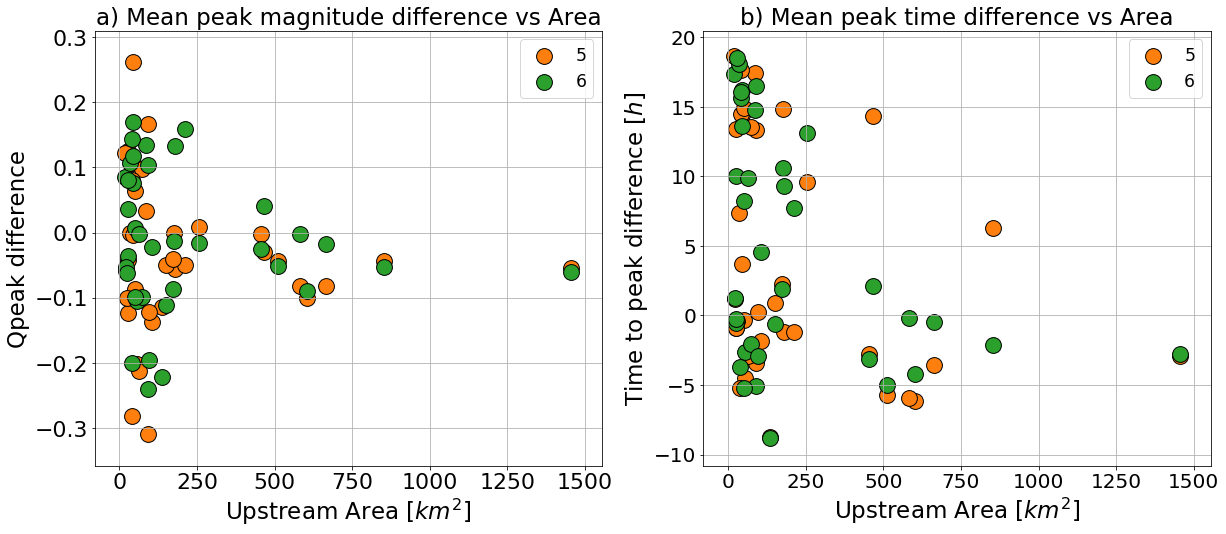

In [108]:
fig = pl.figure(figsize=(20,8))

ax = fig.add_subplot(121)
for i,co in zip(['5','6'],[ '#ff7f0e','#2ca02c' ]):
    ax.scatter(Qp[i]['acum'], Qp[i]['qpeakDiff'], c =  co,s = 250,edgecolor = 'k', label = i)
ax.tick_params(labelsize = 22)
ax.legend(loc = 0, fontsize = 'xx-large')
ax.grid()
ax.set_ylabel('Qpeak difference', size = 23)
ax.set_xlabel('Upstream Area [$km^2$]', size = 23)
ax.set_title('a) Mean peak magnitude difference vs Area', size = 23)
#ax.set_xscale('log')

ax = fig.add_subplot(122)
for i,co in zip(['5','6'],[ '#ff7f0e','#2ca02c' ]):
    ax.scatter(Qp[i]['acum'], Qp[i]['tpeakDiff'],c=co, s = 250,edgecolor = 'k', label = i)
ax.tick_params(labelsize = 20)
ax.legend(loc = 0, fontsize = 'xx-large')
ax.grid()
# ax.set_xlim(10,2000)
# ax.set_xscale('log')
ax.set_ylabel('Time to peak difference [$h$]', size = 23)
ax.set_xlabel('Upstream Area [$km^2$]', size = 23)
ax.set_title('b) Mean peak time difference vs Area', size = 23)

pl.savefig('figures/qpeak_mag_time_mean_diff_vs_area.png', bbox_inches = 'tight')

## Peak flow comparison

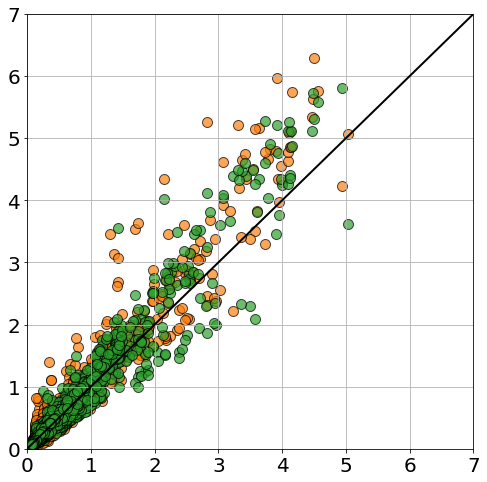

In [145]:
fig  = pl.figure(figsize=(8,8))
ax = fig.add_subplot(111)
bins = np.linspace(10,1000,10)

for i,co in zip(['5','6'],[ '#ff7f0e','#2ca02c' ]):
    x1,y1 = get_qmax_intersec(i, '2002','2018')
    ax.scatter(x1,y1, c = co,s = 100, edgecolors='k', alpha = 0.7, label = '5')
ax.set_xlim(0,7)
ax.set_ylim(0,7)
ax.legend(loc = 0)
ax.plot([0,1000],[0,1000],'k', lw = 2)
ax.set_xlabel('Reference peak flows', size = 22)
ax.set_ylabel('Comparison peak flows', size = 22)
ax.grid()
ax.tick_params(labelsize = 20)

## Standarized qpeak difference

In [103]:
def get_qmax_intersec(product, y1,y2):
    u = M.loc[M['product'] == '4',['qpeak','qmax_anual','link']][y1:y2]
    u.set_index([u.index, 'link'], inplace=True)
    a = M.loc[M['product'] == product,['qpeak','qmax_anual','link']][y1:y2]
    a.set_index([a.index, 'link'], inplace=True)
    idx = a.index.intersection(u.index)
    return u.loc[idx,'qpeak'] / u.loc[idx,'qmax_anual'], a.loc[idx,'qpeak'] / u.loc[idx,'qmax_anual']

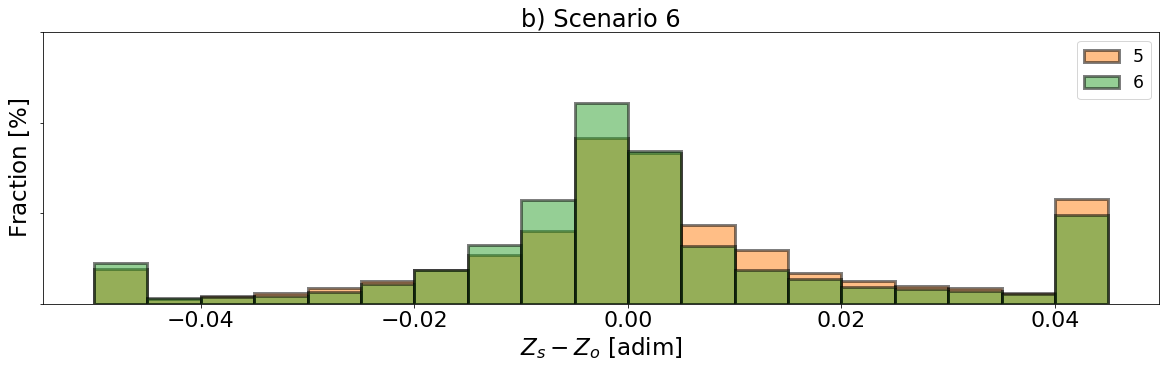

In [121]:
fig = pl.figure(figsize = (20,5))


bins = np.arange(-0.05,0.05,0.005)
x1,y1 = get_qmax_intersec('5', '2002','2018')
er = y1 - x1
h1,b1 = ac.get_histogram(er, bins, inf = bins[0], sup =bins[-1])
cont = 1
names = ['a) Scenario 5','b) Scenario 6','c) Scenario 12']
ax = fig.add_subplot(111)
for prod,co in zip(['5','6'], [ '#ff7f0e','#2ca02c' ]):
    
    
    #Plot the ifc-hlm setup
    #pl.bar(b1[:-1],h1*100, 0.02, align = 'edge',alpha = 0.5, lw = 3, edgecolor = 'k')
    
    #plot one of the best setups
    x2,y2 = get_qmax_intersec(prod,  '2002','2018')
    er2 = y2 - x2    
    h2,b2 = ac.get_histogram(er2, bins, inf = bins[0], sup =bins[-1])
    pl.bar(b2[:-1],h2*100, 0.005, align = 'edge', color = co, alpha = 0.5, lw = 3, edgecolor = 'k', label = prod)
    ax.legend(loc = 0 , fontsize = 'xx-large')
    ax.tick_params(labelsize = 22)
    if cont == 1:
        ax.set_xlabel('$Z_s - Z_o$ [adim]', size = 23)
        ax.set_ylabel('Fraction [$\%$]', size = 23)
    else:
        ax.set_yticklabels([])
    ax.grid()
    ax.set_title(names[cont-1], size = 24)
    #ax.set_ylim(0,35)
    ax.set_yticks([0,10,20,30])
    #ax.set_xticks([-1,-0.5,0.0,0.5,1.0])
    
    cont +=1
pl.savefig('figures/peak_standarized_difference.png', bbox_inches = 'tight')